In [1]:
# Install required libraries
!pip install timm einops tensorboard tqdm

In [6]:
import os
import math
import random
import torch
import torchvision
import numpy as np

from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import timm
from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [16]:
def setup_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(42)


In [17]:
def random_indexes(size):
    forward = np.arange(size)
    np.random.shuffle(forward)
    backward = np.argsort(forward)
    return forward, backward

def take_indexes(x, indexes):
    return torch.gather(x, 0, repeat(indexes, 't b -> t b c', c=x.shape[-1]))


In [18]:
class PatchShuffle(nn.Module):
    def __init__(self, ratio):
        super().__init__()
        self.ratio = ratio

    def forward(self, patches):
        T, B, C = patches.shape
        remain = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward = torch.tensor(np.stack([i[0] for i in indexes], axis=-1)).to(patches.device)
        backward = torch.tensor(np.stack([i[1] for i in indexes], axis=-1)).to(patches.device)

        patches = take_indexes(patches, forward)
        patches = patches[:remain]

        return patches, forward, backward


In [13]:
class MAE_Encoder(nn.Module):
    def __init__(self, image_size=32, patch_size=2, emb_dim=192,
                 num_layer=12, num_head=3, mask_ratio=0.75):
        super().__init__()

        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = nn.Parameter(
            torch.zeros((image_size // patch_size) ** 2, 1, emb_dim)
        )

        self.patchify = nn.Conv2d(3, emb_dim, patch_size, patch_size)
        self.shuffle = PatchShuffle(mask_ratio)

        self.transformer = nn.Sequential(
            *[Block(emb_dim, num_head) for _ in range(num_layer)]
        )

        self.norm = nn.LayerNorm(emb_dim)
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding

        patches, _, backward = self.shuffle(patches)
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)

        patches = rearrange(patches, 't b c -> b t c')
        features = self.norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward


In [14]:
class MAE_Decoder(nn.Module):
    def __init__(self, image_size=32, patch_size=2, emb_dim=192,
                 num_layer=4, num_head=3):
        super().__init__()

        self.mask_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = nn.Parameter(
            torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim)
        )

        self.transformer = nn.Sequential(
            *[Block(emb_dim, num_head) for _ in range(num_layer)]
        )

        self.head = nn.Linear(emb_dim, 3 * patch_size ** 2)
        self.patch2img = Rearrange(
            '(h w) b (c p1 p2) -> b c (h p1) (w p2)',
            p1=patch_size, p2=patch_size, h=image_size//patch_size
        )

        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward):
        T = features.shape[0]

        backward = torch.cat([torch.zeros(1, backward.shape[1]).to(backward), backward + 1])
        features = torch.cat([
            features,
            self.mask_token.expand(backward.shape[0] - T, features.shape[1], -1)
        ])

        features = take_indexes(features, backward)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')[1:]

        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward[1:] - 1)

        return self.patch2img(patches), self.patch2img(mask)


In [11]:
class MAE_ViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MAE_Encoder()
        self.decoder = MAE_Decoder()

    def forward(self, img):
        features, backward = self.encoder(img)
        return self.decoder(features, backward)


In [9]:
transform = Compose([
    ToTensor(),
    Normalize(0.5, 0.5)
])

train_ds = torchvision.datasets.CIFAR10(
    root='data', train=True, download=True, transform=transform
)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)


100%|██████████| 170M/170M [00:19<00:00, 8.68MB/s]


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MAE_ViT().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1.5e-4)
writer = SummaryWriter('logs/mae')

for epoch in range(10):  # increase to 2000 later
    model.train()
    losses = []

    for img, _ in tqdm(train_loader):
        img = img.to(device)
        pred, mask = model(img)
        loss = ((pred - img) ** 2 * mask).mean() / 0.75

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg = sum(losses)/len(losses)
    writer.add_scalar('mae_loss', avg, epoch)
    print(f"Epoch {epoch} | Loss {avg:.4f}")


100%|██████████| 196/196 [02:24<00:00,  1.36it/s]


Epoch 0 | Loss 0.1830


100%|██████████| 196/196 [02:25<00:00,  1.35it/s]


Epoch 1 | Loss 0.1521


100%|██████████| 196/196 [02:23<00:00,  1.37it/s]


Epoch 2 | Loss 0.1385


100%|██████████| 196/196 [02:24<00:00,  1.36it/s]


Epoch 3 | Loss 0.1254


100%|██████████| 196/196 [02:24<00:00,  1.36it/s]


Epoch 4 | Loss 0.1150


100%|██████████| 196/196 [02:23<00:00,  1.36it/s]


Epoch 5 | Loss 0.0951


100%|██████████| 196/196 [02:24<00:00,  1.36it/s]


Epoch 6 | Loss 0.0789


100%|██████████| 196/196 [02:24<00:00,  1.36it/s]


Epoch 7 | Loss 0.0726


100%|██████████| 196/196 [02:24<00:00,  1.36it/s]


Epoch 8 | Loss 0.0686


100%|██████████| 196/196 [02:24<00:00,  1.36it/s]

Epoch 9 | Loss 0.0655


In [11]:
torch.save(model, "vit_t_mae.pt")

In [8]:
class ViT_Classifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.norm = encoder.norm
        self.head = nn.Linear(192, num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches])
        patches = rearrange(patches, 't b c -> b t c')

        features = self.norm(self.transformer(patches))
        return self.head(features[:, 0])

In [12]:
transform = Compose([
    ToTensor(),
    Normalize(0.5, 0.5)
])

train_ds = torchvision.datasets.CIFAR10(
    root='data', train=True, download=True, transform=transform
)

val_ds = torchvision.datasets.CIFAR10(
    root='data', train=False, download=True, transform=transform
)

train_loader = DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    val_ds, batch_size=128, shuffle=False, num_workers=2
)


In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# OPTION 1: from pretrained MAE
mae_model = torch.load(
    "vit_t_mae.pt",
    map_location='cpu',
    weights_only=False
)

encoder = mae_model.encoder

# OPTION 2: from scratch (comment above, uncomment below if needed)
# encoder = MAE_Encoder()


In [20]:
classifier = ViT_Classifier(encoder, num_classes=10).to(device)

In [17]:
loss_fn = nn.CrossEntropyLoss()

def accuracy(logits, labels):
    return (logits.argmax(dim=1) == labels).float().mean()

optimizer = torch.optim.AdamW(
    classifier.parameters(),
    lr=1e-3 * 128 / 256,   # same LR scaling as repo
    betas=(0.9, 0.999),
    weight_decay=0.05
)

total_epochs = 20
warmup_epochs = 5

lr_fn = lambda epoch: min(
    (epoch + 1) / (warmup_epochs + 1e-8),
    0.5 * (math.cos(epoch / total_epochs * math.pi) + 1)
)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_fn)


In [20]:
val_ds = torchvision.datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transform
)

val_loader = DataLoader(
    val_ds,
    batch_size=128,
    shuffle=False,
    num_workers=2
)

In [22]:
best_val_acc = 0.0

for epoch in range(total_epochs):
    # ---- TRAIN ----
    classifier.train()
    train_losses, train_accs = [], []

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        logits = classifier(imgs)
        loss = loss_fn(logits, labels)
        acc = accuracy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(acc.item())

    scheduler.step()

    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_train_acc = sum(train_accs) / len(train_accs)

    # ---- VALIDATION ----
    classifier.eval()
    val_losses, val_accs = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            logits = classifier(imgs)
            loss = loss_fn(logits, labels)
            acc = accuracy(logits, labels)

            val_losses.append(loss.item())
            val_accs.append(acc.item())

    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_acc = sum(val_accs) / len(val_accs)

    print(
        f"Epoch {epoch} | "
        f"Train Acc: {avg_train_acc:.4f} | "
        f"Val Acc: {avg_val_acc:.4f}"
    )

    # Save best model
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(classifier, "vit_classifier_best.pt")
        print("✅ Saved best model")


  1%|          | 2/196 [00:03<06:07,  1.89s/it]


KeyboardInterrupt: 

In [23]:
 device = 'cuda' if torch.cuda.is_available() else 'cpu'

classifier = torch.load(
    "vit_classifier_best.pt",
    map_location=device,
    weights_only=False
)

classifier.eval()


ViT_Classifier(
  (patchify): Conv2d(3, 192, kernel_size=(2, 2), stride=(2, 2))
  (transformer): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=False)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
 

In [22]:
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


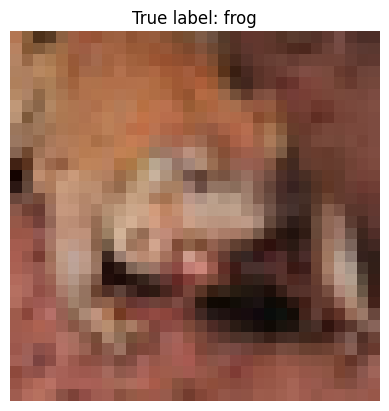

In [25]:
import matplotlib.pyplot as plt

# Take one image from validation set
idx = 5
img, label = val_ds[idx]

# Show image
plt.imshow(((img + 1) / 2).permute(1, 2, 0))
plt.title(f"True label: {classes[label]}")
plt.axis("off")
plt.show()


In [26]:
with torch.no_grad():
    input_img = img.unsqueeze(0).to(device)  # add batch dimension
    logits = classifier(input_img)
    probs = torch.softmax(logits, dim=1)

pred_class = probs.argmax(dim=1).item()
confidence = probs.max().item()

print(f"Predicted label: {classes[pred_class]}")
print(f"Confidence: {confidence:.4f}")


Predicted label: frog
Confidence: 0.7180


In [1]:
from google.colab import files
uploaded = files.upload()

Saving kran.jpeg to kran.jpeg


In [3]:
import matplotlib.pyplot as plt

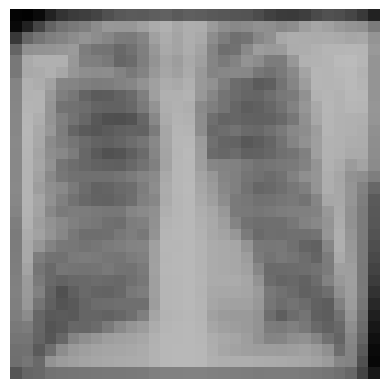

In [4]:
from PIL import Image
from torchvision import transforms

img_path = list(uploaded.keys())[0]
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

img = transform(img)

plt.imshow(((img + 1) / 2).permute(1, 2, 0))
plt.axis("off")
plt.show()


In [23]:
with torch.no_grad():
    logits = classifier(img.unsqueeze(0).to(device))
    probs = torch.softmax(logits, dim=1)

pred = probs.argmax(dim=1).item()
print("Predicted:", classes[pred])


Predicted: airplane
